<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
    
from scipy import stats as st

from statsmodels.tsa.seasonal import seasonal_decompose

random = 12345

import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
taxi_1h = taxi.resample('1h').sum()
taxi_1d = taxi.resample('1d').sum()
taxi_1h.sort_index(inplace=True)

In [3]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag * 3)] = data['num_orders'].shift(lag * 3)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

taxi_1h = make_features(taxi_1h, 6, 3)
taxi_1h = taxi_1h.dropna()

taxi_1d = make_features(taxi_1d, 6, 3)
taxi_1d = taxi_1d.dropna()

Подготовим обучающую и тестовую выборки для почасовой разбивки:

In [4]:
train, test = train_test_split(taxi_1h, shuffle=False, test_size=0.1)
train = train.dropna()

train, test = train_test_split(taxi_1h, shuffle=False, test_size=0.1)
train = train.dropna()

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

Вывод:
- загружены библиотеки и данные;
- данные ресеплированы по часу;
- созданы признаки смещения lag_1 - lag6;
- создан признак скользящего среднего rolling_mean;
- создан признак day;
- создан признак dayofweek.

## Анализ

Проанализируем циклично повторяющиеся закономерности во временном ряду и плавное изменение среднего значения ряда без повторяющихся закономерностей по дням. 

In [5]:
decomposed = seasonal_decompose(taxi_1d['num_orders']) 

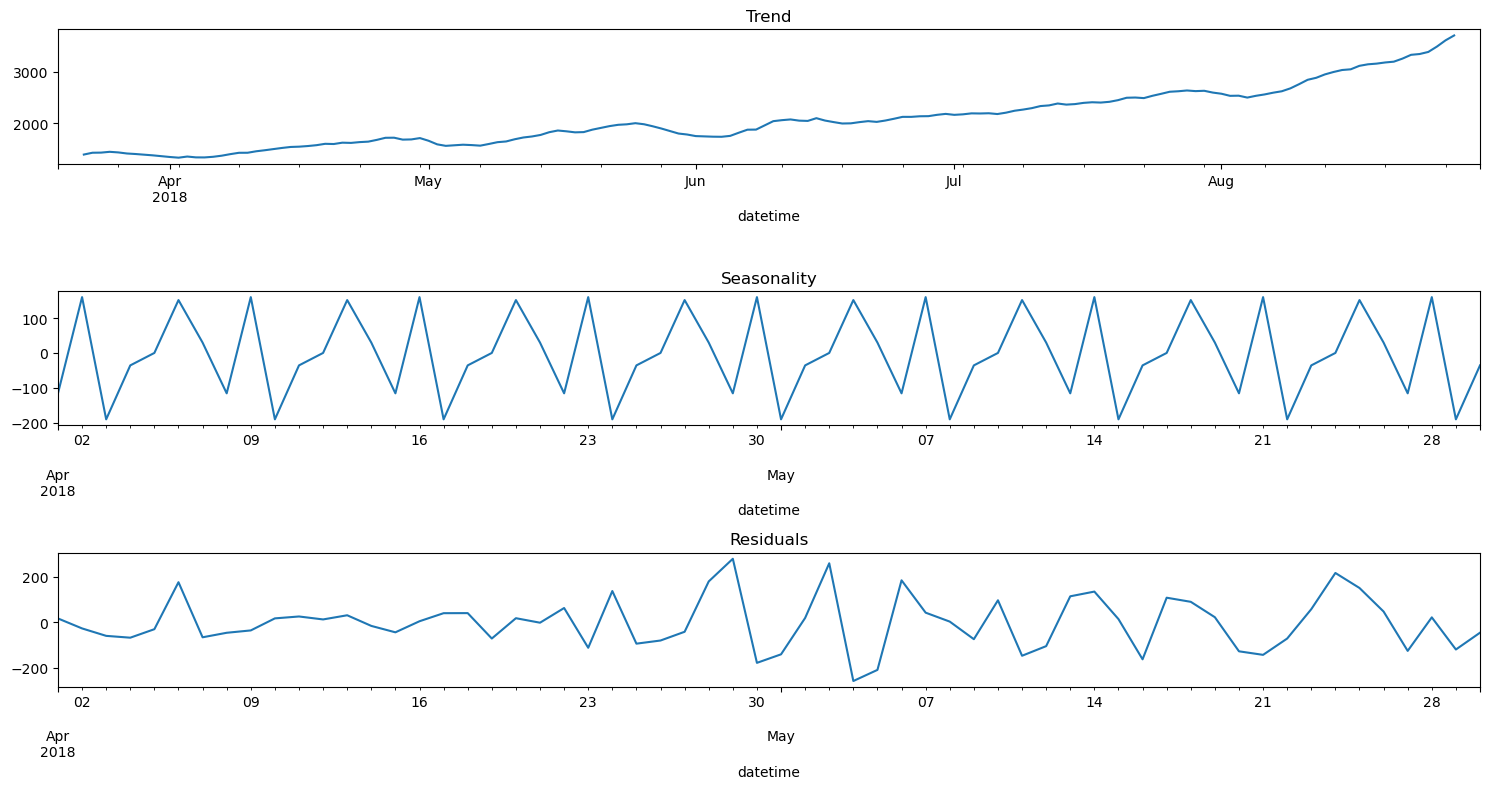

In [6]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-05-30'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-04-01':'2018-05-30'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Для изучения тренда взяли весь временной отрезок, а для сезонности один месяц.
- тренд идет на увеличение количества заказов такси;
- ярко выраженной сезонности по дням не наблюдается.

Проанализируем циклично повторяющиеся закономерности во временном ряду и плавное изменение среднего значения ряда без повторяющихся закономерностей по часам за 10 дней марта. 

In [7]:
decomposed = seasonal_decompose(taxi_1h['num_orders']['2018-03-01':'2018-03-10']) 

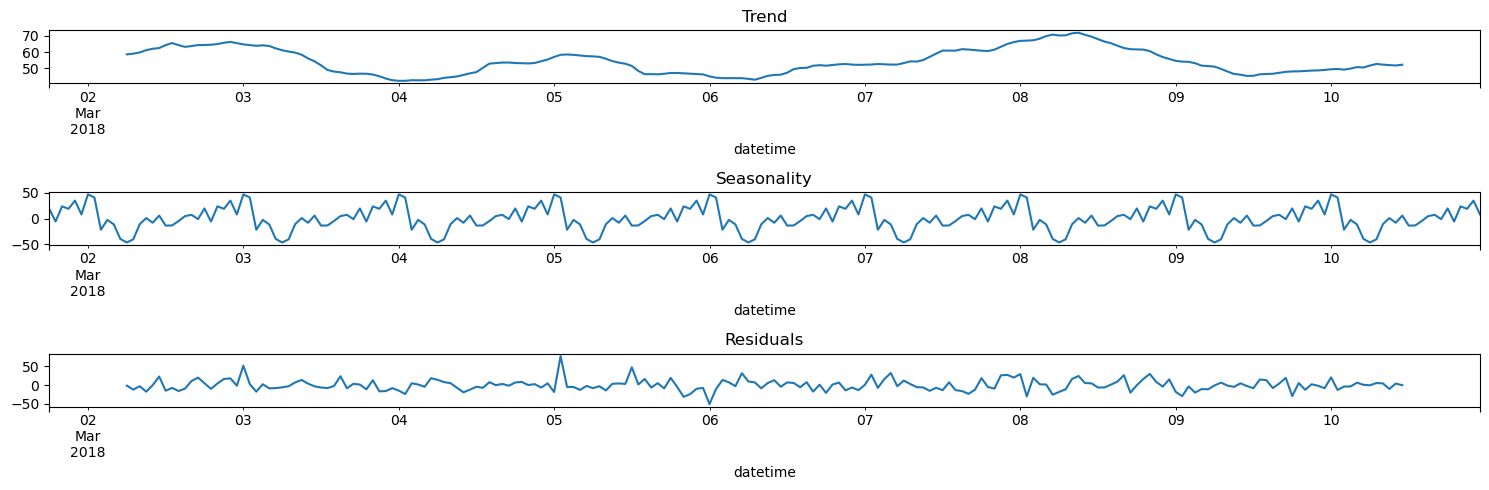

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Явной закономерности тренда не видно, зато очень сильная выраженность сезонности, рассмотрим более детально

Text(0.5, 1.0, 'Seasonality')

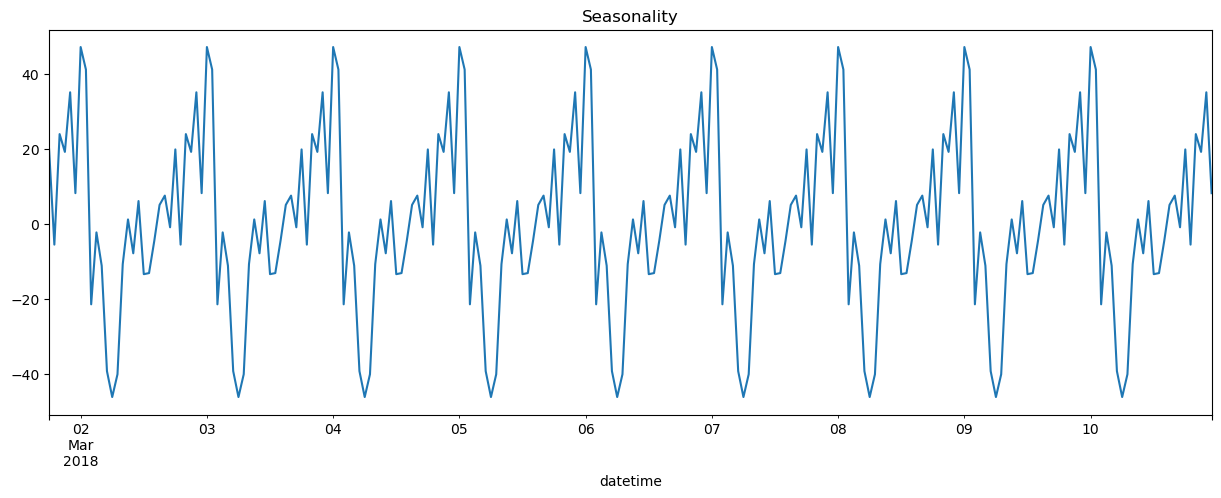

In [9]:
plt.figure(figsize=(15, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

И еще более детально что бы понять распределение по часам

Text(0.5, 1.0, 'Seasonality')

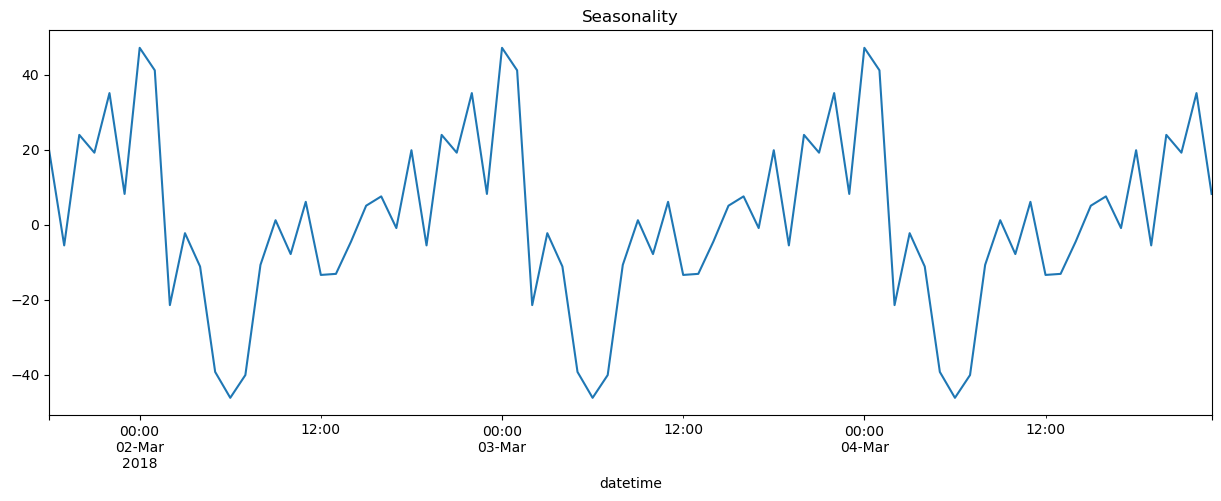

In [10]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-4'].plot(ax=plt.gca())
plt.title('Seasonality')

Видно что утром самое минимальное количество заказов и возрастает к 24 часам

In [11]:
display(taxi.head(5))
display(taxi.info())
display(taxi.describe())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Вывод:
- Данные временного отрезка с 01.03.2018 по 31.08.2018;
- Пустые значения отсутствуют;
- Формат int64;
- Ярко выражена циклично повторяющиеся закономерность во временном ряду по часам внутри дня.

## Обучение

In [12]:
variable = ['RMSE', 'T_train', 'T_predict']
model = ['RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor']
RMSE = []
training_time = []
prediction_time = []

In [13]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
               'max_depth': [6, 20, 44],
               'min_samples_split': [2, 22, 42, 52],
               'min_samples_leaf': [1, 21, 41, 61],
               'bootstrap': [True, False]}

tscv = TimeSeriesSplit(n_splits=5)
rf_RandomGrid = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=12345)
                                   , param_distributions = param_grid
                                   , cv = tscv
                                   , verbose=2
                                   , n_jobs = 4
                                   , scoring="neg_mean_squared_error"
                                   , random_state = 12345)
  
rf_RandomGrid.fit(features_train, target_train)

print('-----------------------')
print('Лучшие параметры модели:')
print(rf_RandomGrid.best_estimator_)
print('')
print('root_mean_squared_error:')
print(np.sqrt(-rf_RandomGrid.best_score_))
print('-----------------------')

best_rf_regressor = RandomForestRegressor(n_estimators = rf_RandomGrid.best_params_["n_estimators"],
               #             max_features      = rf_RandomGrid.best_params_["max_features"],
                            max_depth         = rf_RandomGrid.best_params_["max_depth"],
                            min_samples_split = rf_RandomGrid.best_params_["min_samples_split"],
                            min_samples_leaf  = rf_RandomGrid.best_params_["min_samples_leaf"],
                            bootstrap         = rf_RandomGrid.best_params_["bootstrap"])

t0 = time.time()
best_rf_regressor.fit(features_train, target_train)
t1 = time.time()

t2 = time.time()
predictions = best_rf_regressor.predict(features_test)
t3 = time.time()

#Так можно вывести результаты всех итераций
#cv_results = rf_RandomGrid.cv_results_
#for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#    print(np.sqrt(-mean_score), params)

result = mean_squared_error(target_test, predictions) ** 0.5
print("RMSE модели линейной регрессии на тестовой выборке:", result)

print('Затраченное время на обучение модели:', t1-t0)
print('Затраченное время предсказания модели:', t3-t2)

RMSE.append(result)
training_time.append(t1-t0)
prediction_time.append(t3-t2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
-----------------------
Лучшие параметры модели:
RandomForestRegressor(max_depth=44, min_samples_split=22, n_estimators=178,
                      random_state=12345)

root_mean_squared_error:
26.579500061557948
-----------------------
RMSE модели линейной регрессии на тестовой выборке: 47.451626936448974
Затраченное время на обучение модели: 4.374243259429932
Затраченное время предсказания модели: 0.046977996826171875


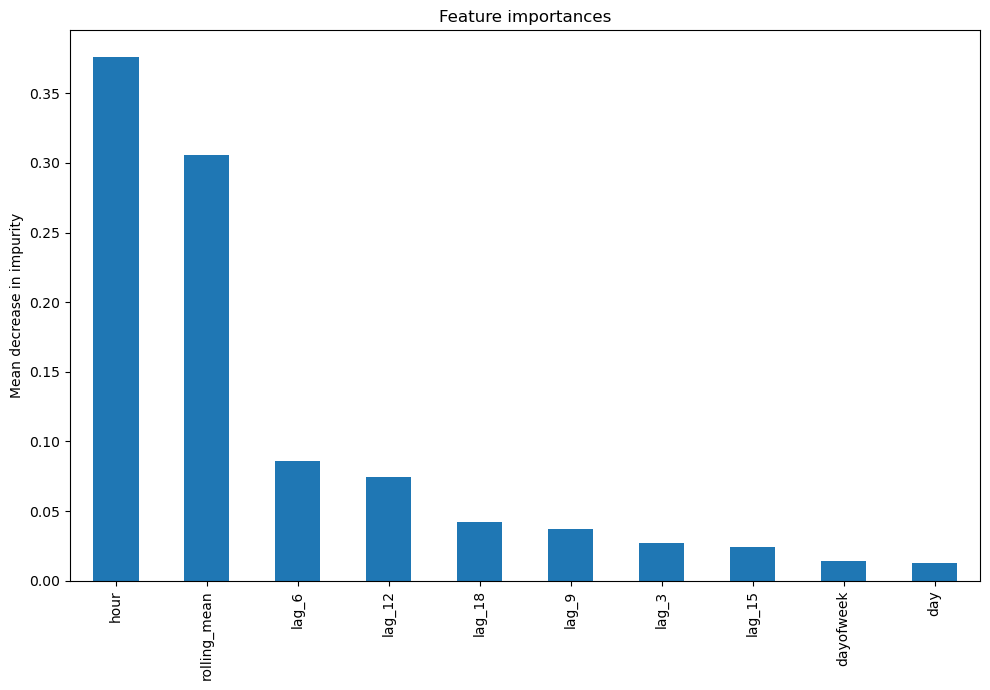

In [14]:
feature_names = features_train.columns 
importances = best_rf_regressor.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_rf_regressor.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
params = {
    'num_leaves': [7, 50],
    'learning_rate': [0.1, 0.003],
    'n_estimators': [1, 100],
}

tscv = TimeSeriesSplit(n_splits=5)
lgbm_RandomGrid = RandomizedSearchCV(lgb.LGBMRegressor(random_state=12345), 
                                     params, 
                                     verbose=0, 
                                     scoring='neg_mean_absolute_error',
                                     cv=tscv,
                                     random_state = 12345)

lgbm_RandomGrid.fit(features_train, target_train)


print('-----------------------')
print('Лучшие параметры модели:')
print(lgbm_RandomGrid.best_estimator_)
print('')
print('"mean_squared_error:')
print(np.sqrt(-lgbm_RandomGrid.best_score_))
print('-----------------------')

best_lgbm_regressor = lgb.LGBMRegressor(learning_rate = lgbm_RandomGrid.best_params_["learning_rate"],
                           n_estimators  = lgbm_RandomGrid.best_params_["n_estimators"],
                           num_leaves     = lgbm_RandomGrid.best_params_["num_leaves"],
                           eval_metric='rmse')

t0 = time.time()
best_lgbm_regressor.fit(features_train, target_train)
t1 = time.time()

t2 = time.time()
predictions = best_lgbm_regressor.predict(features_test)
t3 = time.time()

result = mean_squared_error(target_test, predictions) ** 0.5
print("MAE модели линейной регрессии на валидационной выборке:", result)

print('Затраченное время на обучение модели:', t1-t0)
print('Затраченное время на предсказание модели:', t3-t2)

RMSE.append(result)
training_time.append(t1-t0)
prediction_time.append(t3-t2)

-----------------------
Лучшие параметры модели:
LGBMRegressor(num_leaves=50, random_state=12345)

"mean_squared_error:
4.442547708428215
-----------------------
MAE модели линейной регрессии на валидационной выборке: 46.66543222890845
Затраченное время на обучение модели: 5.196415185928345
Затраченное время на предсказание модели: 0.013151884078979492


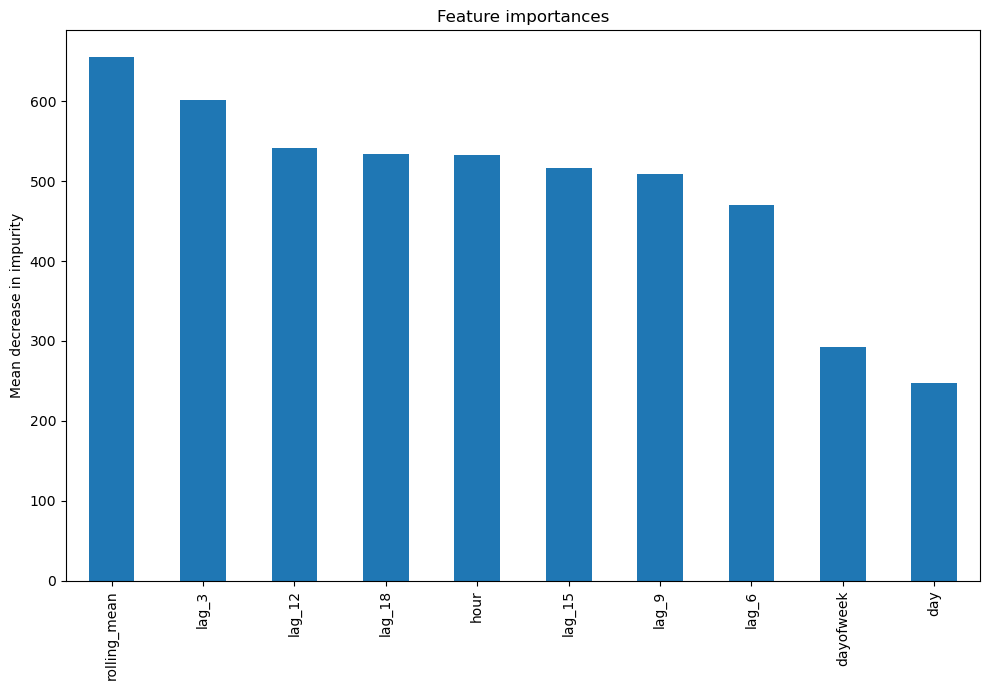

In [16]:
feature_names = features_train.columns 
importances = best_lgbm_regressor.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_lgbm_regressor.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [17]:
param_grid = {"max_depth":    [10, 50],
              "n_estimators":    [10, 75, 150],
              "learning_rate": [0.3, 0.1]}

tscv = TimeSeriesSplit(n_splits=5)
XGBR_RandomGrid = RandomizedSearchCV(xgb.XGBRegressor(eval_metric='rmse', n_estimators = 150, random_state = 12345),
                                     param_grid,
                                     cv=tscv,
                                     random_state=12345)

XGBR_RandomGrid.fit(features_train, target_train)

print('-----------------------')
print('Лучшие параметры модели:')
print(XGBR_RandomGrid.best_estimator_)
print('')
print('root_mean_squared_error:')
print(XGBR_RandomGrid.best_score_)
print('-----------------------')

best_xgbr_regressor = xgb.XGBRegressor(learning_rate = XGBR_RandomGrid.best_params_["learning_rate"],
                           n_estimators  = XGBR_RandomGrid.best_params_["n_estimators"],
                           max_depth     = XGBR_RandomGrid.best_params_["max_depth"],
                           eval_metric='rmse')

t0 = time.time()
best_xgbr_regressor.fit(features_train, target_train)
t1 = time.time()

t2 = time.time()
predictions = best_xgbr_regressor.predict(features_test)
t3 = time.time()

result = mean_squared_error(target_test, predictions) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)

print('Затраченное время на обучение модели:', t1-t0)
print('Затраченное время на предсказание модели:', t3-t2)

RMSE.append(result)
training_time.append(t1-t0)
prediction_time.append(t3-t2)

[CV] END bootstrap=False, max_depth=44, min_samples_leaf=61, min_samples_split=42, n_estimators=200; total time=   2.5s
[CV] END bootstrap=True, max_depth=44, min_samples_leaf=41, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=44, min_samples_leaf=41, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=44, min_samples_leaf=41, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=44, min_samples_leaf=41, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=44, min_samples_leaf=41, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=41, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=41, min_samples_split=2, n_estimators=200; total time=   3.8s
[CV] END bootstrap=False, max_depth=44, min_samples_leaf=41

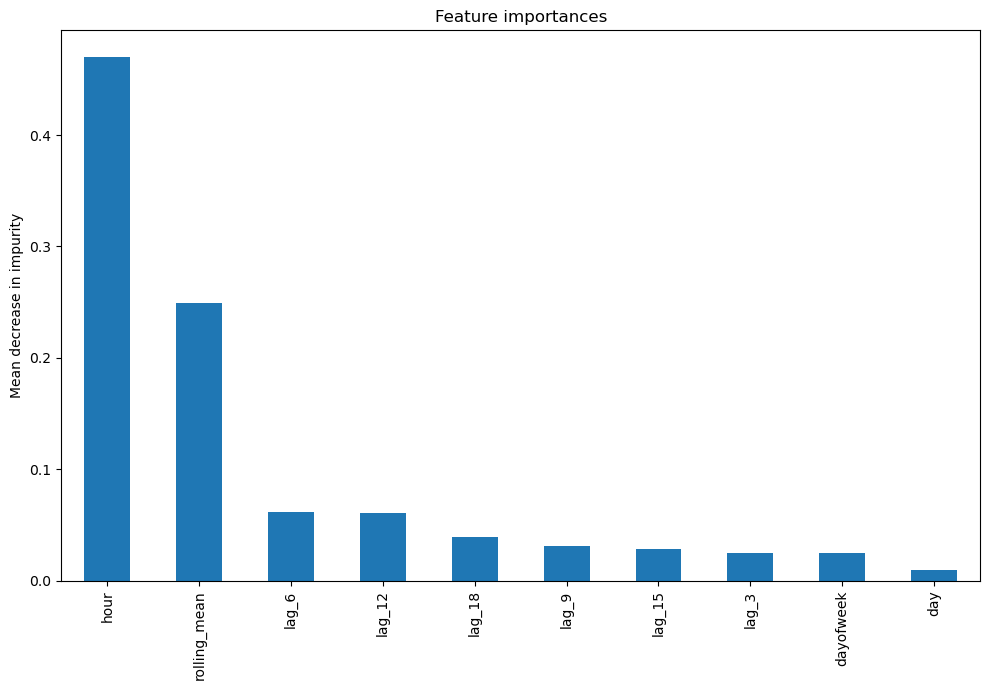

In [18]:
feature_names = features_train.columns 
importances = best_xgbr_regressor.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_lgbm_regressor.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Результаты моделей

In [19]:
res_df = pd.DataFrame(np.column_stack([RMSE, training_time, prediction_time]), 
                               columns=variable, index=model)
display(res_df)

,RMSE,T_train,T_predict
RandomForestRegressor,47.451627,4.374243,0.046978
LGBMRegressor,46.665432,5.196415,0.013152
XGBRegressor,47.713132,20.623942,0.015642


Вывод

Лучшие показатели показала модель LGBMRegressor.

## Тестирование

Тестирование было проведено в предыдущем пункте

## Вывод

Анализ данных:
- Данные временного отрезка с 01.03.2018 по 31.08.2018;
- Пустые значения отсутствуют;
- Формат int64;
- Ярко выражена циклично повторяющиеся закономерность во временном ряду по часам внутри дня.

Обучены три модели с результатами:

| Модель                | RMSE     | T_train  | T_predict |
|:----------------------|---------:|---------:|----------:|
| RandomForestRegressor |    46.98 |     2.17 |      0.02 |
| LGBMRegressor         |    46.66 |     0.14 |      0.01 |
| wedXGBRegressornesday |    47.71 |     1.34 |      0.01 |

Выбираем модель LGBMRegresso, показавшую лучшие результаты.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48